In [1]:
import pandas as pd
import ast
from collections import Counter
from collections import defaultdict
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Load the dataset
tweets_before = pd.read_csv("tweets_before.csv")

In [2]:
# Convert string representation of lists into actual lists
tweets_before['hashtags'] = tweets_before['hashtags'].apply(ast.literal_eval)
tweets_before['mentions'] = tweets_before['mentions'].apply(ast.literal_eval)

# Flatten list of all hashtags and mentions
all_hashtags = [hashtag for sublist in tweets_before['hashtags'] for hashtag in sublist]
all_mentions = [mention for sublist in tweets_before['mentions'] for mention in sublist]

# Count occurrences of each hashtag and mention
hashtag_counts = Counter(all_hashtags)
mention_counts = Counter(all_mentions)

# Convert to DataFrame
hashtags_df = pd.DataFrame(hashtag_counts.items(), columns=['Hashtag', 'Count']).sort_values(by='Count', ascending=False)
mentions_df = pd.DataFrame(mention_counts.items(), columns=['Mention', 'Count']).sort_values(by='Count', ascending=False)

In [3]:
# Top 10 most frequent hashtags before election
print("Top 10 Hashtags Before Election:")
print(hashtags_df.head(10))

Top 10 Hashtags Before Election:
              Hashtag  Count
0     #USElection2024   1424
5              #Trump    354
428      #ElectionDay    313
19      #Election2024    307
1          #Trump2024    259
41      #KamalaHarris    211
580  #FightForAmerica    169
32       #DonaldTrump    131
562  #USAElection2024    100
55            #Kamala     90


In [4]:
# Top 10 most frequent mentions before election
print("Top 10 Mentions Before Election:")
print(mentions_df.head(10))

Top 10 Mentions Before Election:
              Mention  Count
13   @realDonaldTrump     38
1           @elonmusk     26
57      @KamalaHarris     11
4     @PrannoyRoy7749      7
2    @FinancialReview      3
3     @s0meone_u_know      3
43               @CNN      3
10             @Nidhi      3
78           @JDVance      3
154  @hairyharris_sol      2


In [5]:
# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Reload dataset
before_df = pd.read_csv("tweets_before.csv")

# Function to get VADER sentiment scores
def get_vader_sentiment(text):
    scores = sia.polarity_scores(str(text))
    return scores['compound']

# Apply sentiment analysis to 'content'
before_df['sentiment'] = before_df['content'].apply(get_vader_sentiment)

# Display first few rows
before_df[['content', 'sentiment']].head()

,content,sentiment
0,Everyone should Vote! 🇺🇸💪,0.0000
1,📈 🇺🇸As ’s chances of being elected U.S. presid...,0.4404
2,GM $XRD Fam 🌄 13 days left until the . Who's y...,0.0000
3,Aujourd'hui c'est jeudi et le bulletin n°60 de...,0.0000
4,Just in🇺🇸:How Latino Voters Could Decide the E...,0.0000


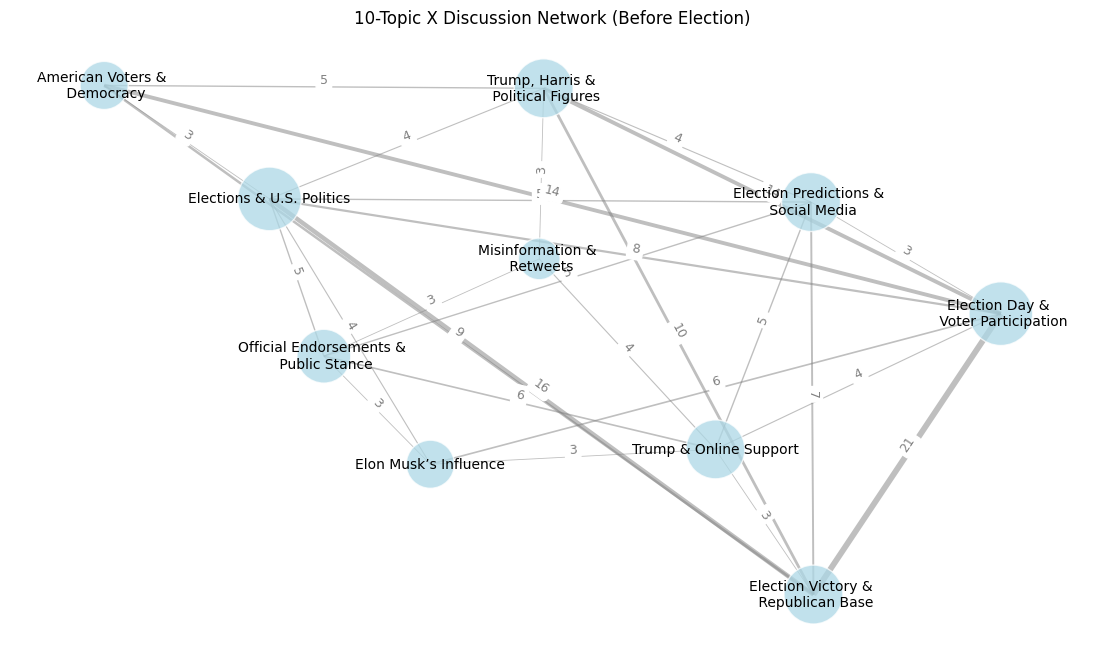

In [6]:
# Extract text from tweets
tweets_before["clean_text"] = tweets_before["content"].astype(str)

# Extract topics using TF-IDF + NMF
vectorizer = TfidfVectorizer(
    stop_words="english", 
    max_features=1000, 
    min_df=3,
    max_df=0.9,
    ngram_range=(1, 2)
)
tfidf_matrix = vectorizer.fit_transform(tweets_before["clean_text"])

nmf = NMF(n_components=10, random_state=42)  # Extract 10 topics
W = nmf.fit_transform(tfidf_matrix)
H = nmf.components_

# Get top keywords for each topic
feature_names = vectorizer.get_feature_names_out()
topic_keywords = {
    f"Topic_{i}": [feature_names[idx] for idx in H[i].argsort()[-7:]] for i in range(10)
}

# Manually assign thematic names based on keywords
topic_names = {
    "Topic_0": "Elections & U.S. Politics",
    "Topic_1": "Trump & Online Support",
    "Topic_2": "Election Predictions & \n Social Media",
    "Topic_3": "Trump, Harris & \n Political Figures",
    "Topic_4": "Official Endorsements & \n Public Stance",
    "Topic_5": "American Voters & \n Democracy",
    "Topic_6": "Elon Musk’s Influence",
    "Topic_7": "Election Victory & \n Republican Base",
    "Topic_8": "Election Day & \n Voter Participation",
    "Topic_9": "Misinformation & \n Retweets",
}

# Assign each tweet a dominant topic
tweets_before["Topic"] = W.argmax(axis=1)
tweets_before["Topic_Label"] = tweets_before["Topic"].apply(lambda x: f"Topic_{x}")

# Aggregate topics into a network
topic_graph = nx.Graph()

# Add topic nodes with renamed labels
for topic, keywords in topic_keywords.items():
    label = topic_names.get(topic, topic)
    topic_graph.add_node(label, size=3000, label=label)

# Count co-occurrences
topic_connections = defaultdict(int)

for _, group in tweets_before.groupby("twitterProfile"):
    topics_mentioned = set(group["Topic_Label"].tolist())
    for t1, t2 in combinations(topics_mentioned, 2):
        topic_connections[(t1, t2)] += 1

# Add topic-to-topic edges if multiple users discuss both
for (t1, t2), weight in topic_connections.items():
    if weight > 2:
        topic_graph.add_edge(topic_names.get(t1, t1), topic_names.get(t2, t2), weight=weight)

# Use Kamada-Kawai layout
pos = nx.kamada_kawai_layout(topic_graph)

plt.figure(figsize=(14, 8))

# Get node degrees to scale sizes
node_sizes = [topic_graph.degree(n) * 300 for n in topic_graph.nodes()]

# Draw topic nodes and connections
nx.draw_networkx_nodes(topic_graph, pos, node_size=node_sizes, node_color="lightblue", edgecolors="white", alpha=0.75)
nx.draw_networkx_edges(topic_graph, pos, width=[d["weight"] * 0.2 for (_, _, d) in topic_graph.edges(data=True)], alpha=0.5, edge_color="gray")

# Format labels
nx.draw_networkx_labels(topic_graph, pos, font_size=10, font_family="sans-serif")

# Add edge labels
edge_labels = {(u, v): d["weight"] for u, v, d in topic_graph.edges(data=True)}
nx.draw_networkx_edge_labels(topic_graph, pos, edge_labels=edge_labels, font_size=9, label_pos=0.5, verticalalignment="bottom", alpha=0.5)

# Plot
plt.gca().set_facecolor("white")
plt.axis("off")
plt.title("10-Topic X Discussion Network (Before Election)", fontsize=12)
plt.show()

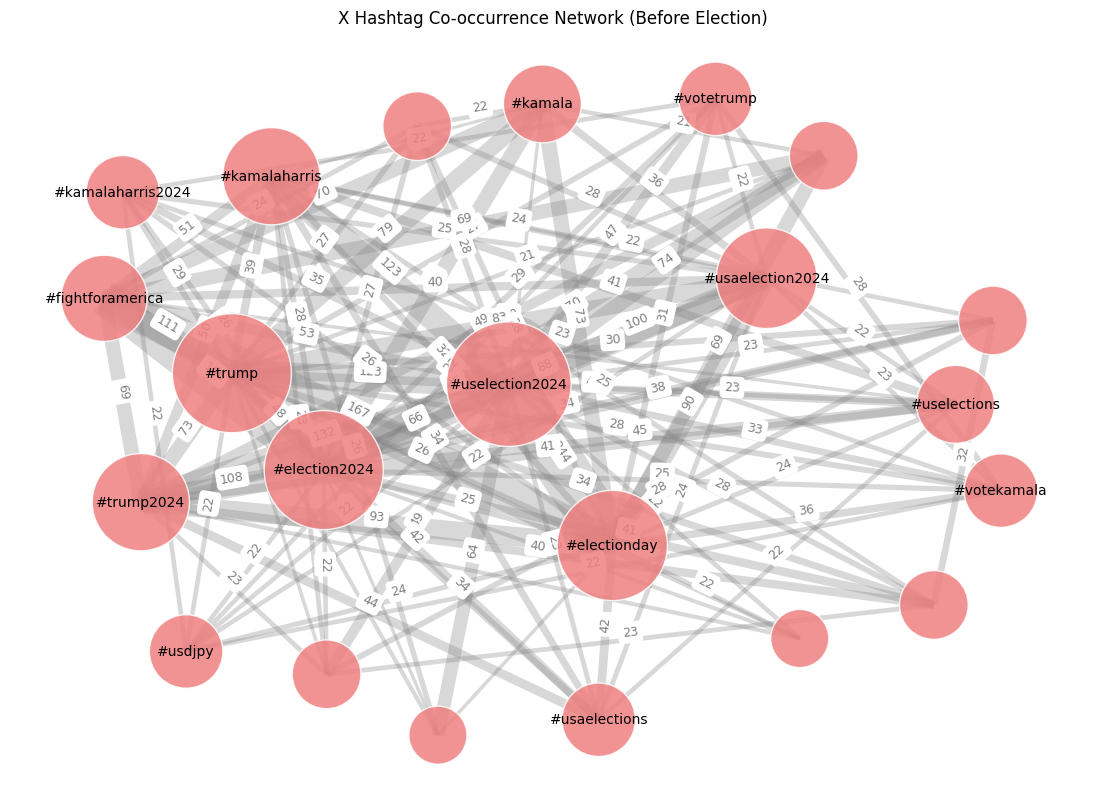

In [7]:
# Set filtering thresholds to reduce noise
edge_threshold = 15
node_degree_threshold = 5

# Create an undirected graph
hashtag_graph = nx.Graph()

# Function to clean and standardize hashtags
def clean_hashtag(ht):
    return ht.lower().strip()

# Count hashtag co-occurrences
co_occurrence_counts = Counter()

# Process hashtag co-occurrences
for hashtags in tweets_before['hashtags']:
    if isinstance(hashtags, list) and len(hashtags) > 1:
        cleaned_hashtags = [clean_hashtag(ht) for ht in hashtags]
        for pair in combinations(cleaned_hashtags, 2):
            co_occurrence_counts[pair] += 1

# Add edges to the graph based on the threshold
for (ht1, ht2), count in co_occurrence_counts.items():
    if count >= edge_threshold:
        hashtag_graph.add_edge(ht1, ht2, weight=count)

# Remove low-degree nodes
low_degree_nodes = [node for node, degree in dict(hashtag_graph.degree()).items() if degree < node_degree_threshold]
hashtag_graph.remove_nodes_from(low_degree_nodes)

# Use Fruchterman-Reingold layout
pos = nx.fruchterman_reingold_layout(hashtag_graph, k=11, scale=7)

plt.figure(figsize=(14, 10))

# Scale nodes based on their degree
node_sizes = [hashtag_graph.degree(n) * 350 for n in hashtag_graph.nodes()]

# Draw hashtag nodes and connections
nx.draw_networkx_nodes(hashtag_graph, pos, node_size=node_sizes, node_color="lightcoral", edgecolors="white", alpha=0.85)
nx.draw_networkx_edges(hashtag_graph, pos, width=[d["weight"] * 0.15 for (_, _, d) in hashtag_graph.edges(data=True)], alpha=0.3, edge_color="gray")

# Label highly connected hashtags
high_degree_nodes = [node for node, degree in hashtag_graph.degree() if degree > 7]
nx.draw_networkx_labels(hashtag_graph, pos, labels={node: node for node in high_degree_nodes}, font_size=10, font_family="sans-serif")

# Add edge labels for stronger connections
edge_labels = {(u, v): d["weight"] for u, v, d in hashtag_graph.edges(data=True) if d["weight"] > 20}
nx.draw_networkx_edge_labels(hashtag_graph, pos, edge_labels=edge_labels, font_size=9, label_pos=0.5, verticalalignment="bottom", alpha=0.5)

# Plot
plt.gca().set_facecolor("white")
plt.axis("off")
plt.title("X Hashtag Co-occurrence Network (Before Election)", fontsize=12)
plt.show()